# Module 06: Training Pipeline - Interactive Notebook

This notebook provides a hands-on walkthrough of training transformer language models.

**Topics Covered:**
1. Dataset creation and exploration
2. Learning rate scheduling
3. Training loop basics
4. Checkpointing and resuming
5. Training visualization
6. Complete end-to-end training

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent.parent.parent))

from tiny_transformer.training import (
    TextDataset,
    CharTokenizer,
    create_data_loaders,
    WarmupCosineScheduler,
    WarmupLinearScheduler,
    Trainer,
    TrainerConfig,
    compute_perplexity,
    set_seed
)
from tiny_transformer.model import TinyTransformerLM, get_model_config

set_seed(42)
print("✓ Imports successful")

✓ Imports successful


## 1. Dataset Creation and Exploration

We'll create a simple text dataset for language modeling.

In [2]:
# Sample text for training
text = """hello world this is a test of the training pipeline. 
we will train a small transformer model on this text. 
the model will learn to predict the next character given previous characters."""

print(f"Text length: {len(text)} characters")
print(f"Unique characters: {len(set(text))}")
print(f"\nFirst 100 characters:\n{text[:100]}")

Text length: 186 characters
Unique characters: 23

First 100 characters:
hello world this is a test of the training pipeline. 
we will train a small transformer model on thi


In [3]:
# Create tokenizer
tokenizer = CharTokenizer()
tokenizer.fit(text)

print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"\nVocabulary: {sorted(tokenizer.vocab.keys())}")

# Encode text
tokens = tokenizer.encode(text)
print(f"\nTotal tokens: {len(tokens)}")
print(f"First 20 tokens: {tokens[:20]}")

Vocabulary size: 23

Vocabulary: ['\n', ' ', '.', 'a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x']

Total tokens: 186
First 20 tokens: [9, 6, 11, 11, 14, 1, 21, 14, 16, 11, 5, 1, 18, 9, 10, 17, 1, 10, 17, 1]


In [4]:
# Create dataset
seq_len = 32
dataset = TextDataset(tokens, seq_len=seq_len)

print(f"Dataset length: {len(dataset)}")
print(f"Sequence length: {seq_len}")

# Get first example
input_ids, target_ids = dataset[0]
print(f"\nInput shape: {input_ids.shape}")
print(f"Target shape: {target_ids.shape}")

# Decode to verify
input_text = tokenizer.decode(input_ids.tolist())
target_text = tokenizer.decode(target_ids.tolist())

print(f"\nInput:  '{input_text}'")
print(f"Target: '{target_text}'")

Dataset length: 5
Sequence length: 32

Input shape: torch.Size([32])
Target shape: torch.Size([32])

Input:  'hello world this is a test of th'
Target: 'ello world this is a test of the'


## 2. Learning Rate Scheduling

Visualize warmup + cosine decay learning rate schedule.

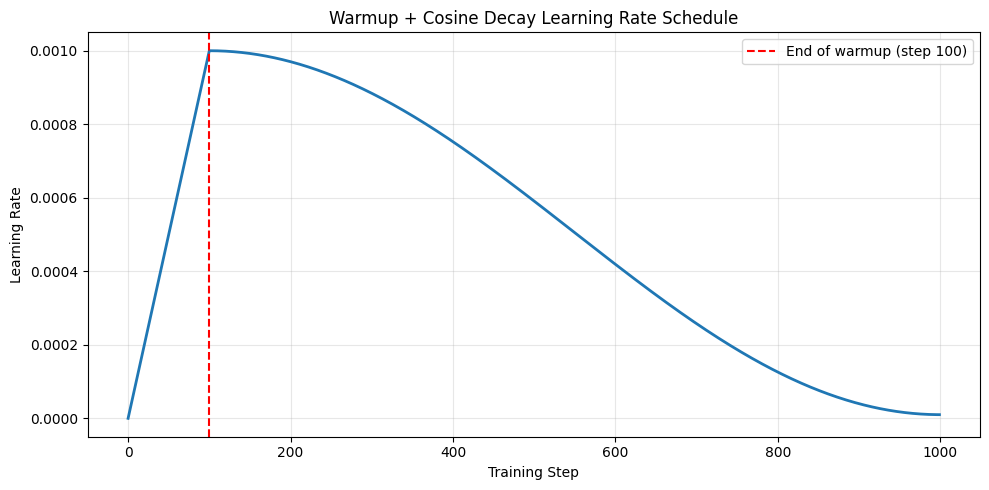

Initial LR: 0.00e+00
Peak LR (after warmup): 1.00e-03
Final LR: 1.00e-05


In [5]:
# Create dummy model and optimizer
model = nn.Linear(10, 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Create scheduler
warmup_steps = 100
total_steps = 1000
peak_lr = 1e-3
min_lr = 1e-5

scheduler = WarmupCosineScheduler(
    optimizer,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    peak_lr=peak_lr,
    min_lr=min_lr
)

# Collect learning rates
lrs = []
for step in range(total_steps):
    lrs.append(scheduler.get_last_lr()[0])
    # Call optimizer.step() before scheduler.step() to avoid warning
    optimizer.step()
    scheduler.step()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(lrs, linewidth=2)
plt.axvline(warmup_steps, color='r', linestyle='--', label=f'End of warmup (step {warmup_steps})')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.title('Warmup + Cosine Decay Learning Rate Schedule')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Initial LR: {lrs[0]:.2e}")
print(f"Peak LR (after warmup): {lrs[warmup_steps]:.2e}")
print(f"Final LR: {lrs[-1]:.2e}")

## 3. Basic Training Loop

Demonstrate a simple training loop on our tiny dataset.

In [6]:
# Create data loaders
train_loader, _ = create_data_loaders(
    train_tokens=tokens,
    val_tokens=None,
    seq_len=32,
    batch_size=4
)

print(f"Train loader batches: {len(train_loader)}")
print(f"Samples per batch: {train_loader.batch_size}")

# Get first batch
for input_ids, target_ids in train_loader:
    print(f"\nBatch input shape: {input_ids.shape}")
    print(f"Batch target shape: {target_ids.shape}")
    break

Train loader batches: 2
Samples per batch: 4

Batch input shape: torch.Size([4, 32])
Batch target shape: torch.Size([4, 32])


In [7]:
# Create tiny model
tiny_config = get_model_config('tiny')
model = TinyTransformerLM(
    vocab_size=tokenizer.vocab_size,
    **tiny_config
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model config: d_model={tiny_config['d_model']}, n_heads={tiny_config['n_heads']}, n_layers={tiny_config['n_layers']}")

Model parameters: 796,288
Model config: d_model=128, n_heads=4, n_layers=4


In [8]:
# Manual training loop (for illustration)
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

losses = []
num_steps = 50

print("Training for 50 steps...")
for step in range(num_steps):
    for input_ids, target_ids in train_loader:
        # Forward pass
        logits, _ = model(input_ids)
        
        # Compute loss
        loss = nn.functional.cross_entropy(
            logits.view(-1, logits.size(-1)),
            target_ids.view(-1)
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if step % 10 == 0:
            perplexity = compute_perplexity(loss.item())
            print(f"Step {step:3d} | Loss: {loss.item():.4f} | Perplexity: {perplexity:.2f}")
        
        break  # One batch per step

print("\n✓ Training complete")

Training for 50 steps...
Step   0 | Loss: 3.2028 | Perplexity: 24.60
Step  10 | Loss: 2.6239 | Perplexity: 13.79


Step  20 | Loss: 2.1785 | Perplexity: 8.83


Step  30 | Loss: 1.9229 | Perplexity: 6.84
Step  40 | Loss: 1.5729 | Perplexity: 4.82

✓ Training complete


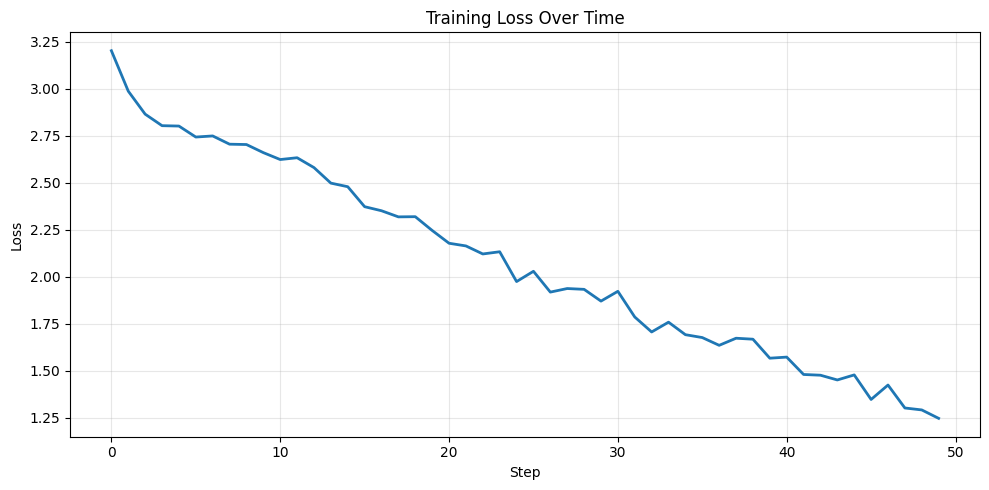

Initial loss: 3.2028
Final loss: 1.2471
Improvement: 61.1%


In [9]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Improvement: {(losses[0] - losses[-1]) / losses[0] * 100:.1f}%")

## 4. Using the Trainer Class

Use the high-level Trainer interface for production training.

In [10]:
# Create fresh model and data
set_seed(42)
model = TinyTransformerLM(
    vocab_size=tokenizer.vocab_size,
    **tiny_config
)

train_loader, _ = create_data_loaders(
    train_tokens=tokens,
    val_tokens=None,
    seq_len=32,
    batch_size=4
)

# Configure trainer
config = TrainerConfig(
    learning_rate=1e-3,
    weight_decay=0.01,
    grad_clip=1.0,
    log_interval=10,
    max_steps=100,
    warmup_steps=20,
    device='cpu'
)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    config=config
)

print("Trainer configured")
print(f"Optimizer: {type(trainer.optimizer).__name__}")
print(f"Scheduler: {type(trainer.scheduler).__name__}")
print(f"Device: {trainer.device}")

Trainer configured
Optimizer: AdamW
Scheduler: WarmupCosineScheduler
Device: cpu


In [11]:
# Train using Trainer
final_metrics = trainer.train()

print("\n" + "="*70)
print("Training Complete!")
print("="*70)
print(f"Final loss: {final_metrics['loss']:.4f}")
print(f"Final perplexity: {final_metrics['perplexity']:.2f}")
print(f"Total steps: {trainer.step}")

Starting Training
Device: cpu
Training samples: 5
Config: TrainerConfig(learning_rate=0.001, weight_decay=0.01, betas=(0.9, 0.95), grad_clip=1.0, log_interval=10, eval_interval=500, save_interval=1000, max_steps=100, num_epochs=10, warmup_steps=20, device='cpu', checkpoint_dir='checkpoints', pad_token_id=None)



Epoch 4 | Step 10 | Loss: 2.9081 | PPL: 18.32 | LR: 5.00e-04 | Grad: 2.22
Epoch 9 | Step 20 | Loss: 2.7705 | PPL: 15.97 | LR: 1.00e-03 | Grad: 1.93


Epoch 14 | Step 30 | Loss: 2.3096 | PPL: 10.07 | LR: 9.66e-04 | Grad: 2.22


Epoch 19 | Step 40 | Loss: 2.1131 | PPL: 8.27 | LR: 8.68e-04 | Grad: 1.90


Epoch 24 | Step 50 | Loss: 1.9248 | PPL: 6.85 | LR: 7.22e-04 | Grad: 3.09
Epoch 29 | Step 60 | Loss: 1.8755 | PPL: 6.52 | LR: 5.50e-04 | Grad: 2.47


Epoch 34 | Step 70 | Loss: 1.6084 | PPL: 4.99 | LR: 3.78e-04 | Grad: 2.56


Epoch 39 | Step 80 | Loss: 1.4895 | PPL: 4.43 | LR: 2.32e-04 | Grad: 2.33


Epoch 44 | Step 90 | Loss: 1.5133 | PPL: 4.54 | LR: 1.34e-04 | Grad: 3.25
Epoch 49 | Step 100 | Loss: 1.3322 | PPL: 3.79 | LR: 1.00e-04 | Grad: 2.22
Reached max_steps (100). Stopping training.

Training Complete! Time: 0s

Training Complete!
Final loss: 1.3695
Final perplexity: 3.93
Total steps: 100


## 5. Checkpointing

Save and load model checkpoints.

In [12]:
# Save checkpointcheckpoint_filename = "temp_checkpoint.pt"trainer.save_checkpoint(checkpoint_filename)# Get the full path where it was actually savedcheckpoint_path = trainer.checkpoint_dir / checkpoint_filenameprint(f"✓ Checkpoint saved to {checkpoint_path}")print(f"\nCheckpoint contains:")checkpoint = torch.load(checkpoint_path)for key in checkpoint.keys():    print(f"  - {key}")

In [13]:
# Load checkpoint into new modelnew_model = TinyTransformerLM(    vocab_size=tokenizer.vocab_size,    **tiny_config)new_trainer = Trainer(    model=new_model,    train_loader=train_loader,    config=config)new_trainer.load_checkpoint(str(checkpoint_path))print(f"✓ Checkpoint loaded")print(f"Resumed at step: {new_trainer.step}")print(f"Resumed at epoch: {new_trainer.epoch}")# Clean upimport osos.remove(checkpoint_path)print(f"✓ Temporary checkpoint removed")

## 6. Training Metrics Visualization

Visualize loss, perplexity, and learning rate during training.

In [14]:
# Simulate training with metrics collection
set_seed(42)
model = TinyTransformerLM(vocab_size=tokenizer.vocab_size, **tiny_config)
train_loader, _ = create_data_loaders(tokens, None, 32, 4)

config = TrainerConfig(
    learning_rate=1e-3,
    max_steps=200,
    warmup_steps=40,
    log_interval=10,
    device='cpu'
)

# Manual training with metric tracking
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = WarmupCosineScheduler(
    optimizer, 
    warmup_steps=40, 
    total_steps=200, 
    peak_lr=1e-3, 
    min_lr=1e-5
)

model.train()
losses = []
lrs = []
steps = []

print("Training for 200 steps with metric collection...")
step = 0
while step < 200:
    for input_ids, target_ids in train_loader:
        logits, _ = model(input_ids)
        loss = nn.functional.cross_entropy(
            logits.view(-1, logits.size(-1)),
            target_ids.view(-1)
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(step)
        
        step += 1
        if step >= 200:
            break

print("✓ Training complete")

Training for 200 steps with metric collection...


✓ Training complete


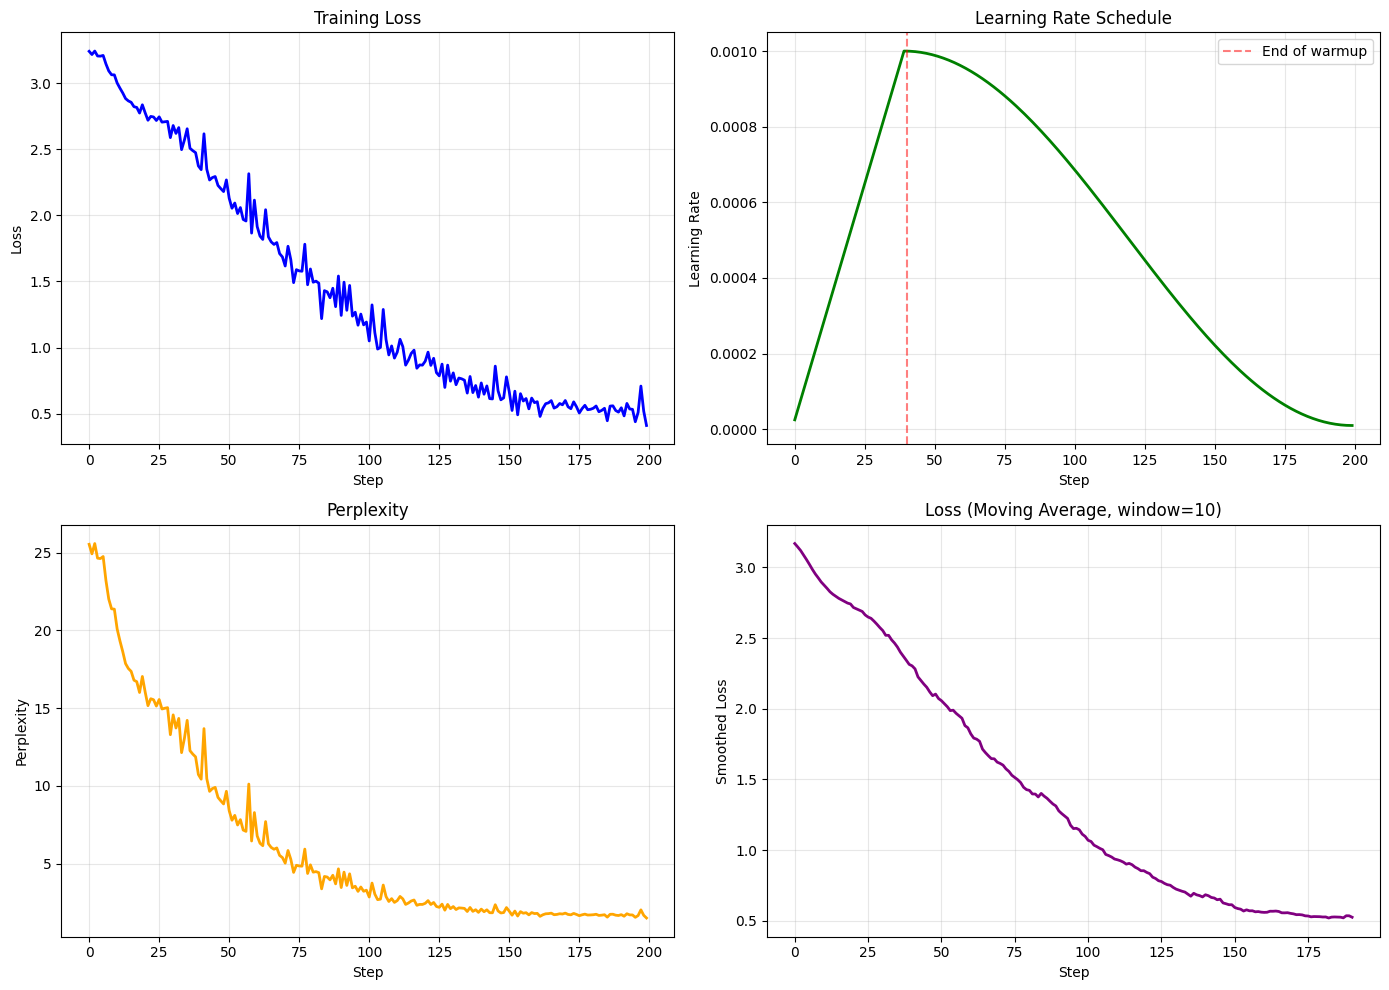


Training Summary:
  Initial loss: 3.2402 → Final loss: 0.4107
  Initial perplexity: 25.54 → Final perplexity: 1.51
  Loss reduction: 87.3%


In [15]:
# Create comprehensive training visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(steps, losses, linewidth=2, color='blue')
axes[0, 0].set_xlabel('Step')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].grid(True, alpha=0.3)

# Learning rate
axes[0, 1].plot(steps, lrs, linewidth=2, color='green')
axes[0, 1].axvline(40, color='r', linestyle='--', alpha=0.5, label='End of warmup')
axes[0, 1].set_xlabel('Step')
axes[0, 1].set_ylabel('Learning Rate')
axes[0, 1].set_title('Learning Rate Schedule')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Perplexity
perplexities = [compute_perplexity(l) for l in losses]
axes[1, 0].plot(steps, perplexities, linewidth=2, color='orange')
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Perplexity')
axes[1, 0].set_title('Perplexity')
axes[1, 0].grid(True, alpha=0.3)

# Smoothed loss (moving average)
window = 10
smoothed_loss = np.convolve(losses, np.ones(window)/window, mode='valid')
axes[1, 1].plot(steps[:len(smoothed_loss)], smoothed_loss, linewidth=2, color='purple')
axes[1, 1].set_xlabel('Step')
axes[1, 1].set_ylabel('Smoothed Loss')
axes[1, 1].set_title(f'Loss (Moving Average, window={window})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining Summary:")
print(f"  Initial loss: {losses[0]:.4f} → Final loss: {losses[-1]:.4f}")
print(f"  Initial perplexity: {perplexities[0]:.2f} → Final perplexity: {perplexities[-1]:.2f}")
print(f"  Loss reduction: {(losses[0] - losses[-1]) / losses[0] * 100:.1f}%")

## Summary

In this notebook, we explored:

1. **Dataset Creation** - Using TextDataset and CharTokenizer for character-level language modeling
2. **Learning Rate Scheduling** - Warmup + cosine decay for stable training
3. **Training Loops** - Both manual and Trainer-based approaches
4. **Checkpointing** - Saving and resuming training state
5. **Metrics Visualization** - Loss, perplexity, and learning rate tracking

**Next Steps:**
- Try the exercises in `exercises/exercises.py`
- Train on larger datasets (Shakespeare, WikiText)
- Experiment with different hyperparameters
- Move on to Module 07 (Sampling & Generation)